# Predict Bike Sharing Demand with AutoGluon

This notebook contains a pipeline to predict bike rental demand using historic usage data and weather data. The data can be accessed from [Bike Sharing Demand](https://www.kaggle.com/competitions/bike-sharing-demand) Kaggle website.

## Step 1: Create an account with Kaggle

### Create Kaggle Account and download API key
Below is example of steps to get the API username and key. Each student will have their own username and key.

1. Open account settings.
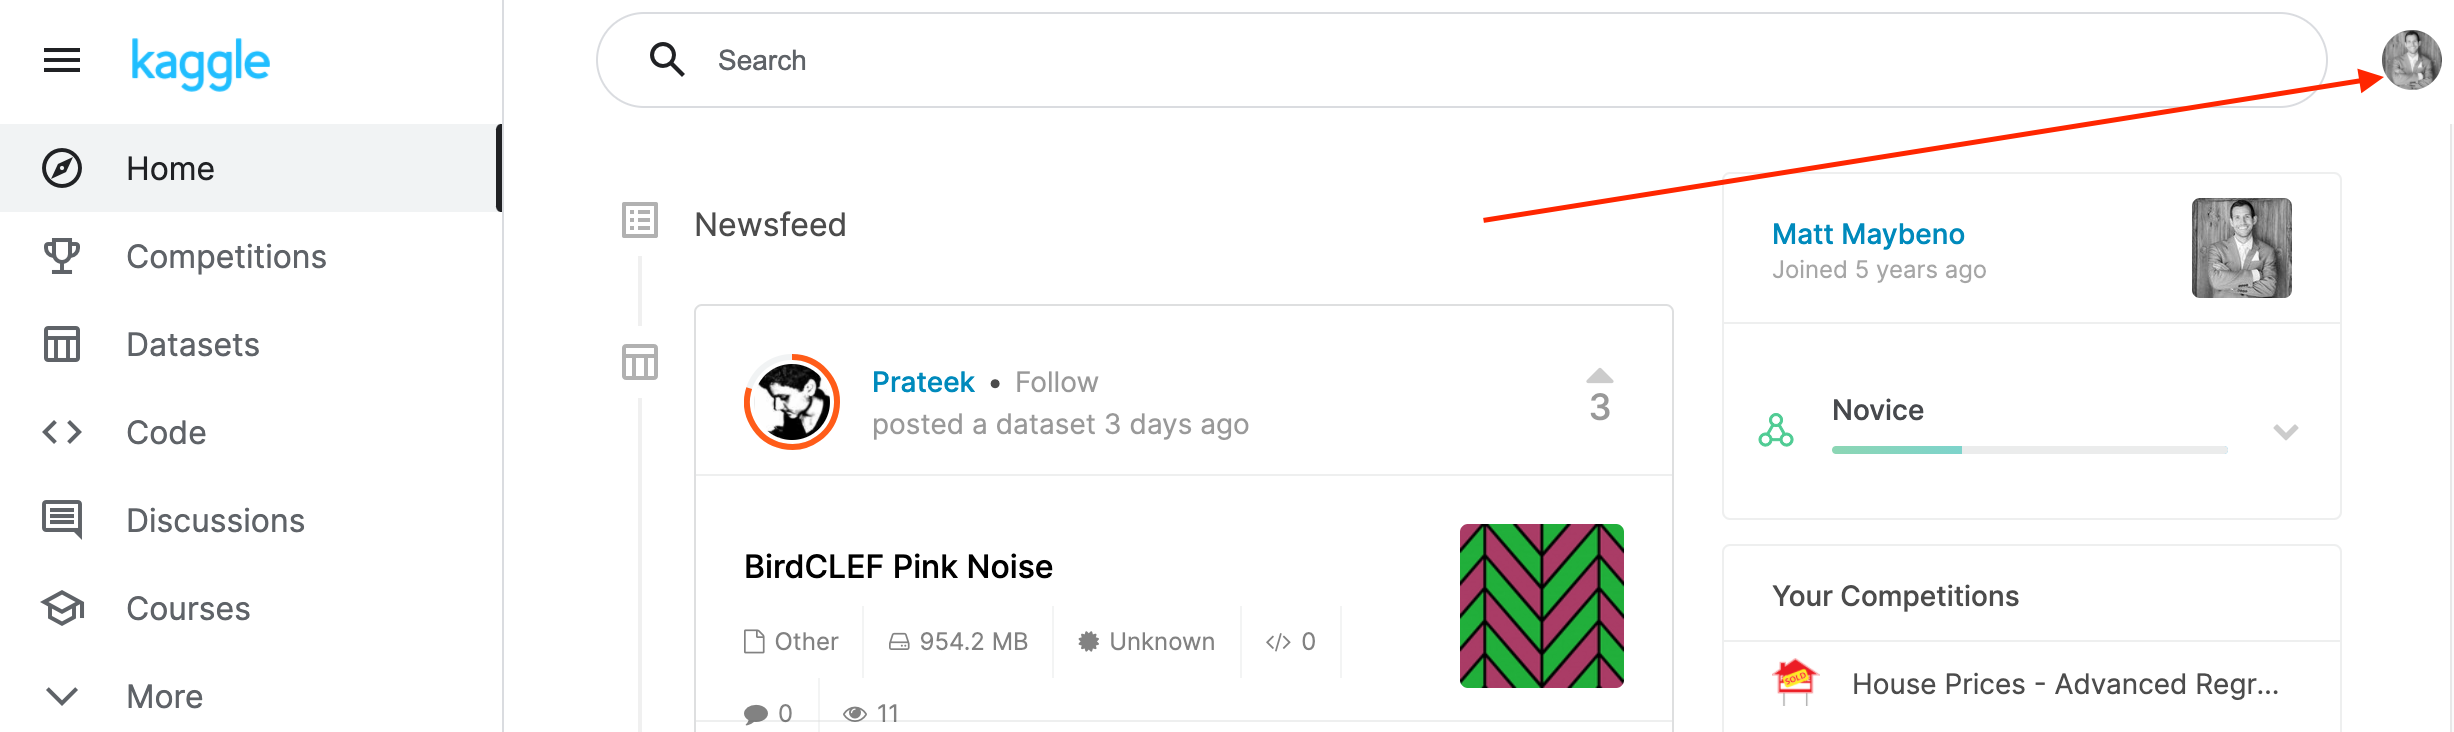
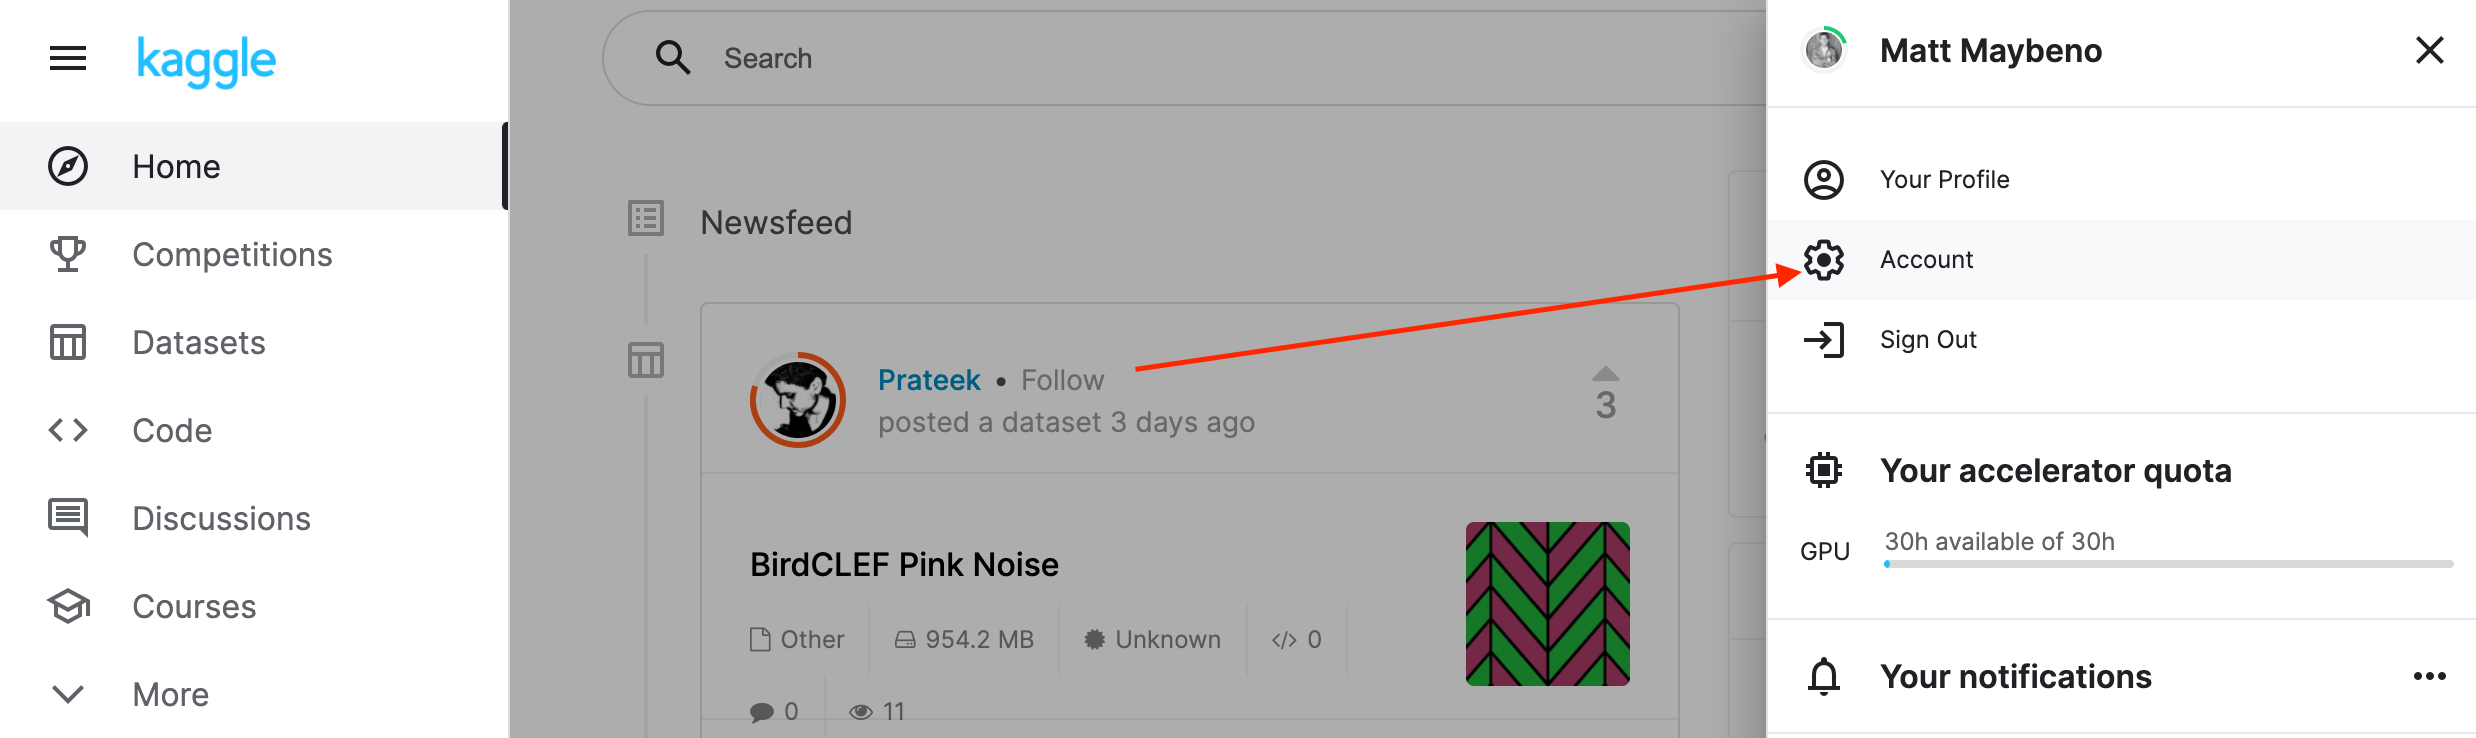
2. Scroll down to API and click Create New API Token.
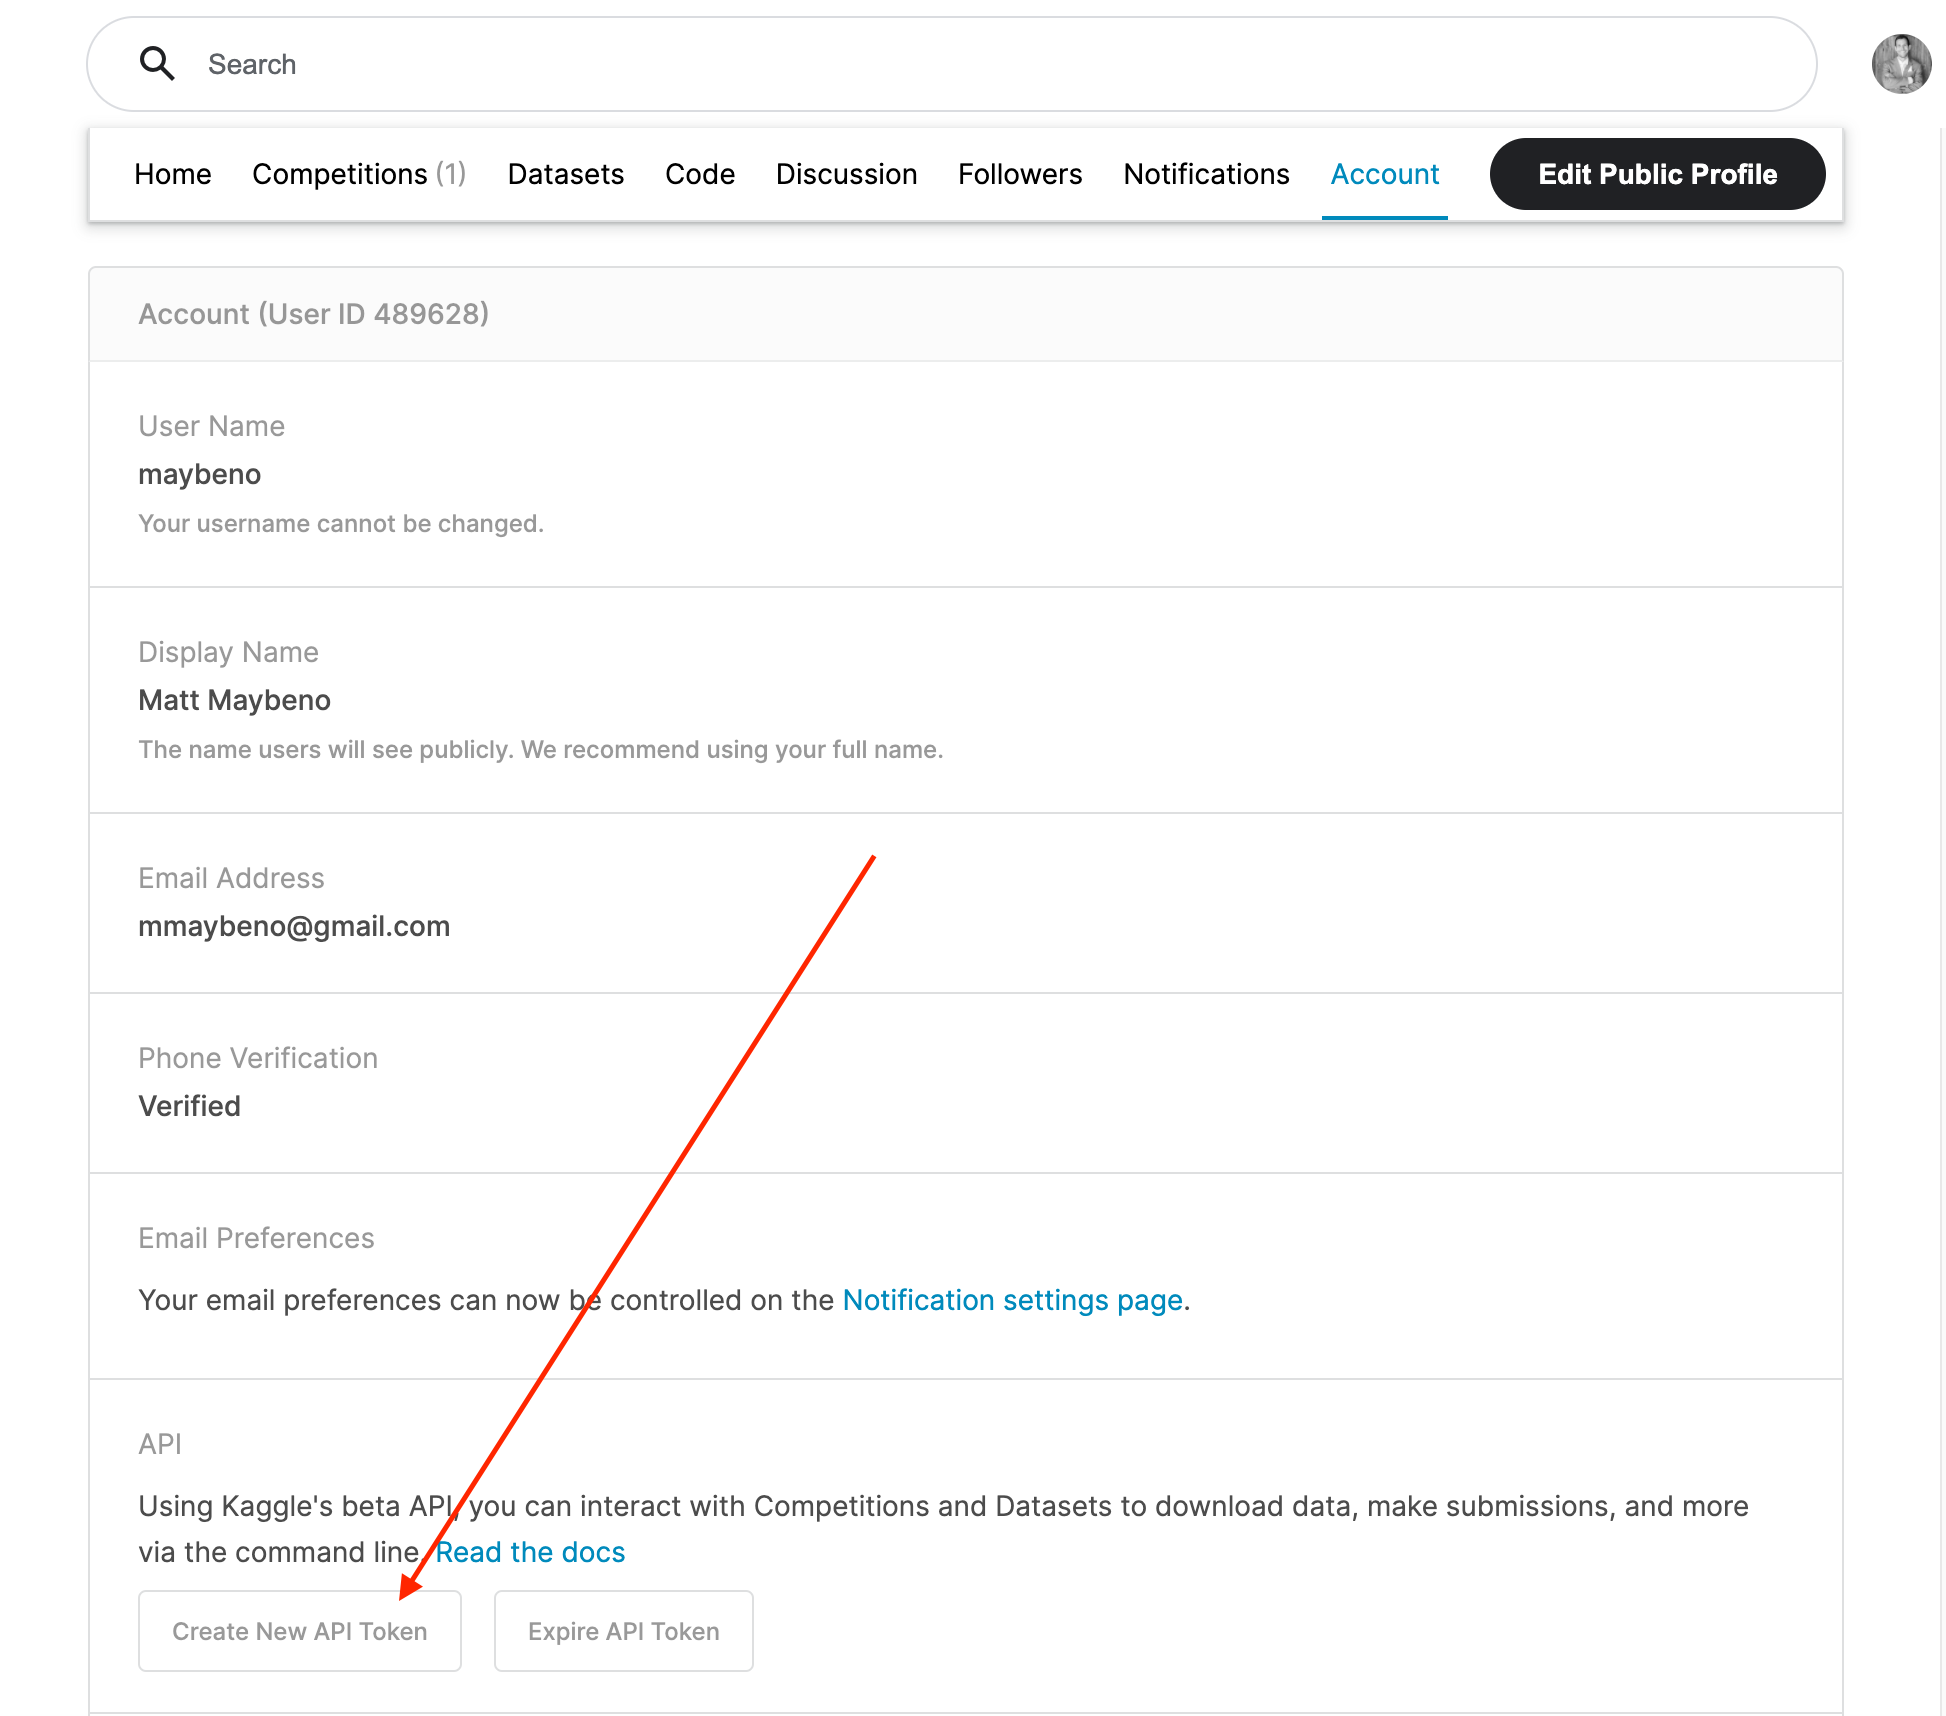
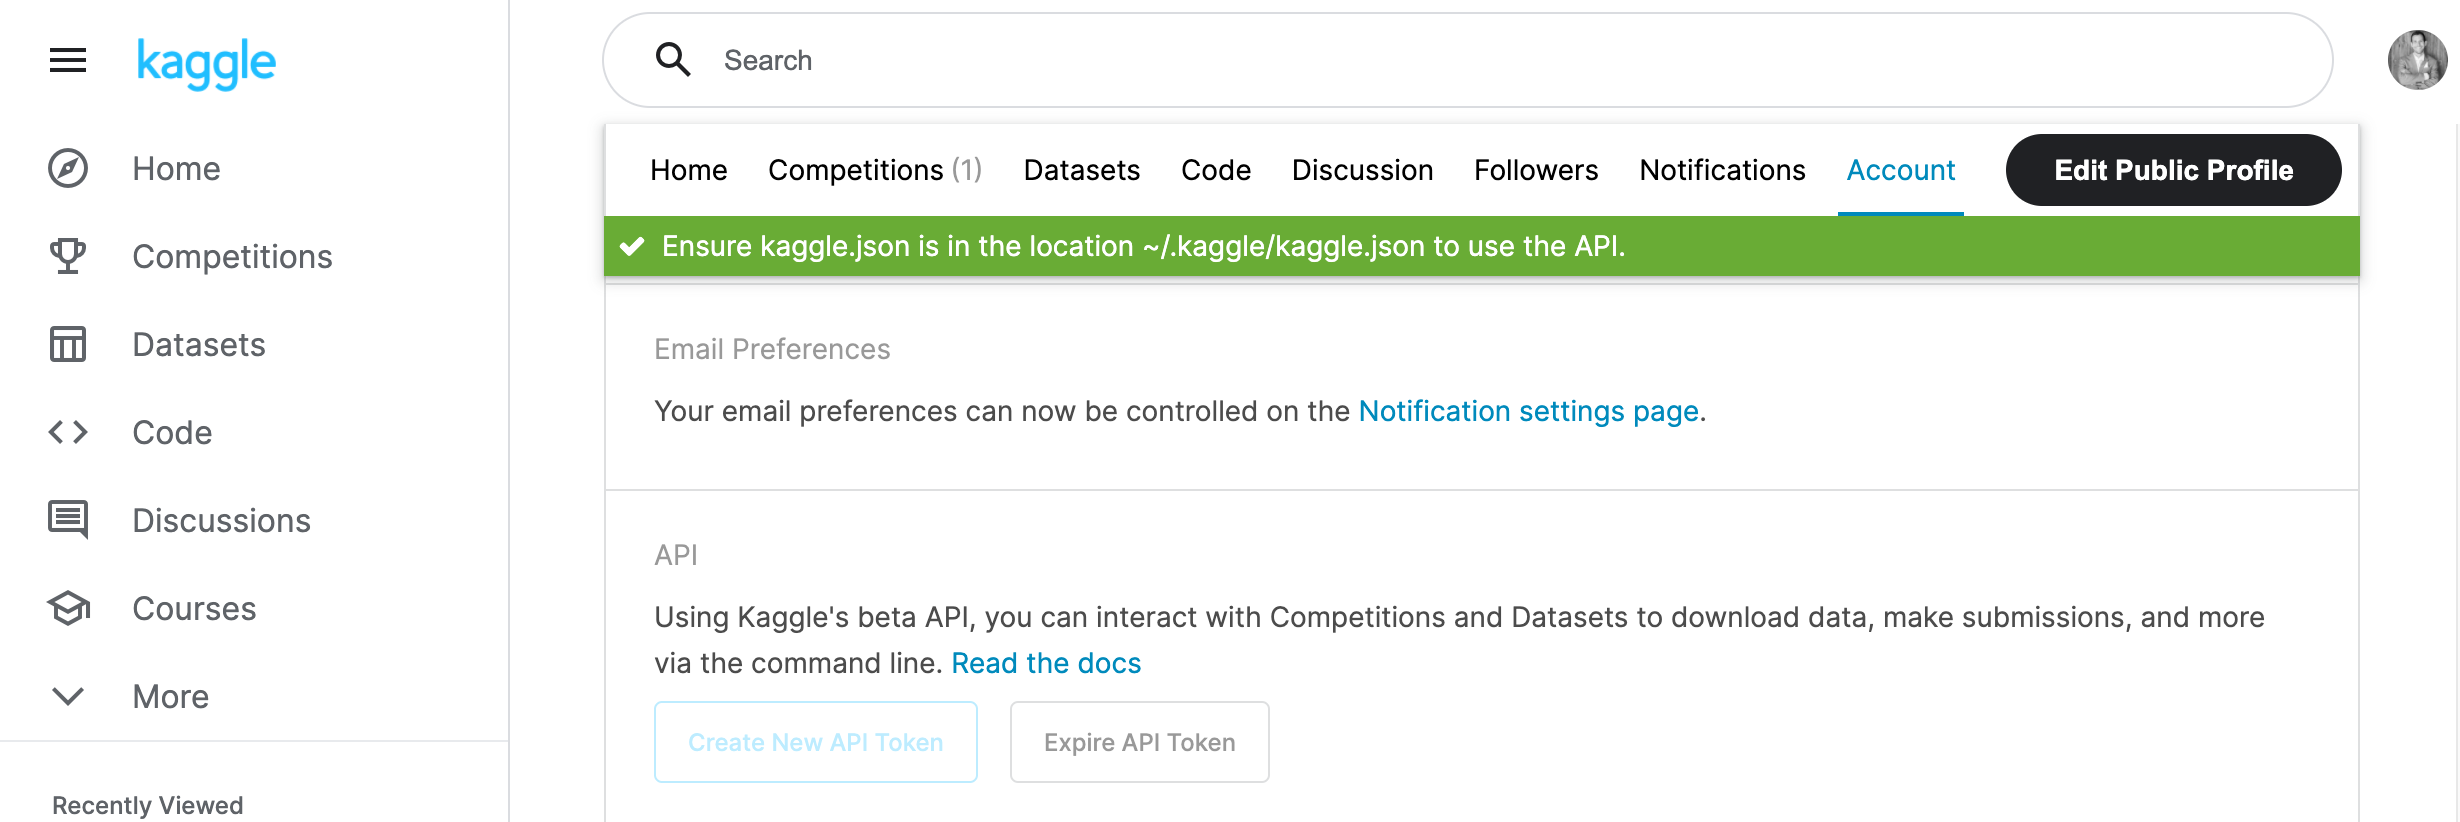
3. Open up `kaggle.json` and use the username and key.
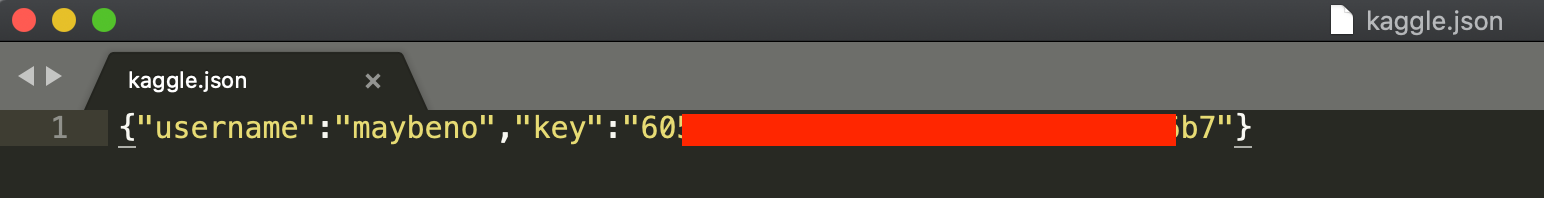

## Step 2: Download the Kaggle dataset using the kaggle python library

### Open up Sagemaker Studio and use starter template

This notebook was tested on AWS Segemaker Studio using `ml.t3.medium` instance (2 vCPU + 4 GiB)


### Install packages

In [ ]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

In [22]:
!pip install -q kaggle

### Setup Kaggle API Key

In [ ]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p ~/.kaggle
!touch ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
# Fill in your user name and key from creating the kaggle account and API token file
import json
kaggle_username = "YOUR_KAGGLE_USER_NAME"
kaggle_key = "YOUR_KAGGLE_KEY"

# Save API token the kaggle.json file
with open("/home/sagemaker-user/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

### Download and explore dataset

### Go to the bike sharing demand competition and agree to the terms
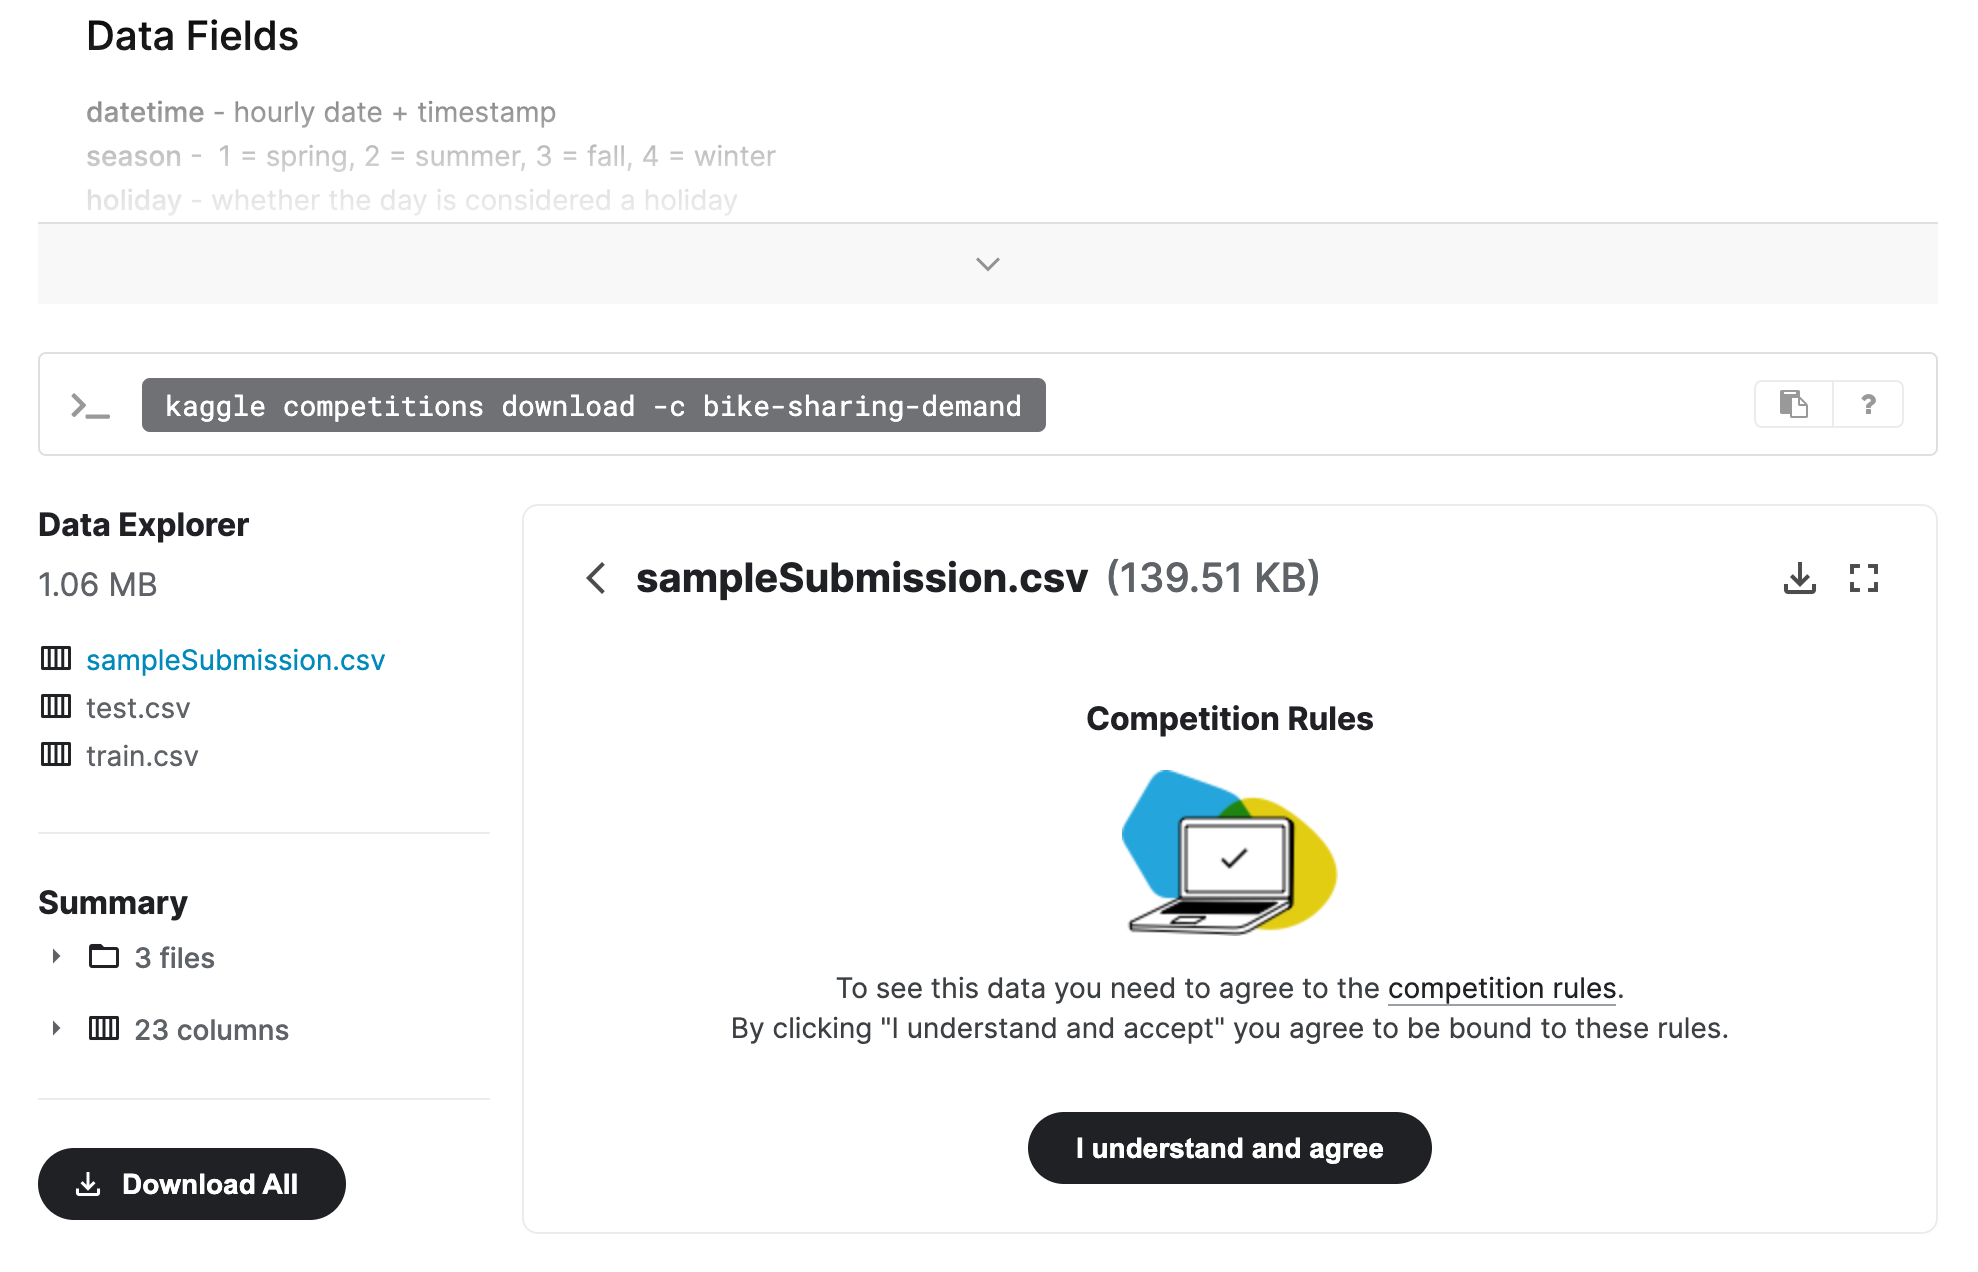

In [4]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

  0%|                                                | 0.00/189k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 189k/189k [00:00<00:00, 26.0MB/s]
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [2]:
import pandas as pd
from autogluon.tabular import TabularPredictor

/home/sagemaker-user/.conda/envs/mle/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv("train.csv")
train.datetime = pd.to_datetime(train.datetime)
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [5]:
# check if there are missing values
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [6]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv("test.csv")
test.datetime = pd.to_datetime(test.datetime)
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [7]:
# Same thing as train and test dataset
submission = pd.read_csv("sampleSubmission.csv")
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [8]:
# Check if the order of 'datetime' column values are the same in the sampleSubmission.csv and test.csv files
assert all(submission.datetime.eq(test.datetime)), "order different"

In [9]:
# Training csv has features that are not available in test (casual and registered)
# remove these fearture except, 'count' columns
features = test.columns.to_list()
train = train[features + ['count']]

## Step 3: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are prediting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [10]:
predictor = TabularPredictor(label='count', problem_type='regression', 
                             eval_metric='root_mean_squared_error').fit(train, 
                                                                        time_limit=600, 
                                                                        presets="best_quality")

No path specified. Models will be saved in: "AutogluonModels/ag-20240805_125106/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20240805_125106/"
AutoGluon Version:  0.6.2
Python Version:     3.7.16
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Jun 18 14:00:06 UTC 2024
Train Data Rows:    10886
Train Data Columns: 9
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2237.63 MB
	Train Data (Original)  Memory Usage: 0.78 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note:

### Review AutoGluon's training run with ranking of models that did the best.

In [11]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -53.040612      23.605002  519.972356                0.000937           0.268620            3       True         14
1   RandomForestMSE_BAG_L2  -53.316143      18.181615  425.545748                0.970037          36.773234            2       True         12
2          LightGBM_BAG_L2  -55.038557      17.470988  415.344043                0.259411          26.571529            2       True         11
3          CatBoost_BAG_L2  -56.382178      17.335901  428.388390                0.124324          39.615876            2       True         13
4        LightGBMXT_BAG_L2  -60.257575      22.374617  456.358973                5.163040          67.586459            2       True         10
5    KNeighborsDist_BAG_L1  -84.125061       0.106793    0.084782         

/home/sagemaker-user/.conda/envs/mle/lib/python3.7/site-packages/autogluon/core/utils/plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446146,
  'KNeighborsDist_BAG_L1': -84.12506123181544,
  'LightGBMXT_BAG_L1': -131.46090891834507,
  'LightGBM_BAG_L1': -131.05416159889887,
  'RandomForestMSE_BAG_L1': -116.

### Get best model

In [ ]:
predictor.get_model_best()

### Create predictions from test dataset

In [13]:
predictions = predictor.predict(test)
predictions.head()

0    22.561790
1    42.703106
2    45.674286
3    48.427372
4    51.381584
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [14]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean      100.672829
std        89.848824
min         3.540813
25%        20.199343
50%        63.244415
75%       167.713501
max       366.432007
Name: count, dtype: float64

In [17]:
# How many negative values do we have?
print("All model prediction are greater than zero")

All model prediction are greater than zero


In [18]:
# Set them to zero
predictions[predictions < 0] = 0

### Set predictions to submission dataframe, save, and submit

In [23]:
# since count is integer,round and convert to int the model prediction 
submission["count"] = predictions.round().astype("int64")
submission.to_csv("submission.csv", index=False)

In [24]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100%|█████████████████████████████████████████| 148k/148k [00:00<00:00, 210kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [25]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission.csv               2024-08-05 13:04:10  first raw submission               complete  1.79587      1.79587       
submission_new_features.csv  2024-08-05 10:43:24  new features                       complete  0.47077      0.47077       
submission_new_hpo.csv       2024-08-02 18:04:46  new features with hyperparameters  complete  1.31677      1.31677       
submission_new_hpo.csv       2024-08-02 18:02:14  new features with hyperparameters  error                                


#### Initial score of `1.79587`

## Step 4a: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.


array([[<AxesSubplot:title={'center':'datetime'}>,
        <AxesSubplot:title={'center':'season'}>,
        <AxesSubplot:title={'center':'holiday'}>],
       [<AxesSubplot:title={'center':'workingday'}>,
        <AxesSubplot:title={'center':'weather'}>,
        <AxesSubplot:title={'center':'temp'}>],
       [<AxesSubplot:title={'center':'atemp'}>,
        <AxesSubplot:title={'center':'humidity'}>,
        <AxesSubplot:title={'center':'windspeed'}>],
       [<AxesSubplot:title={'center':'count'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

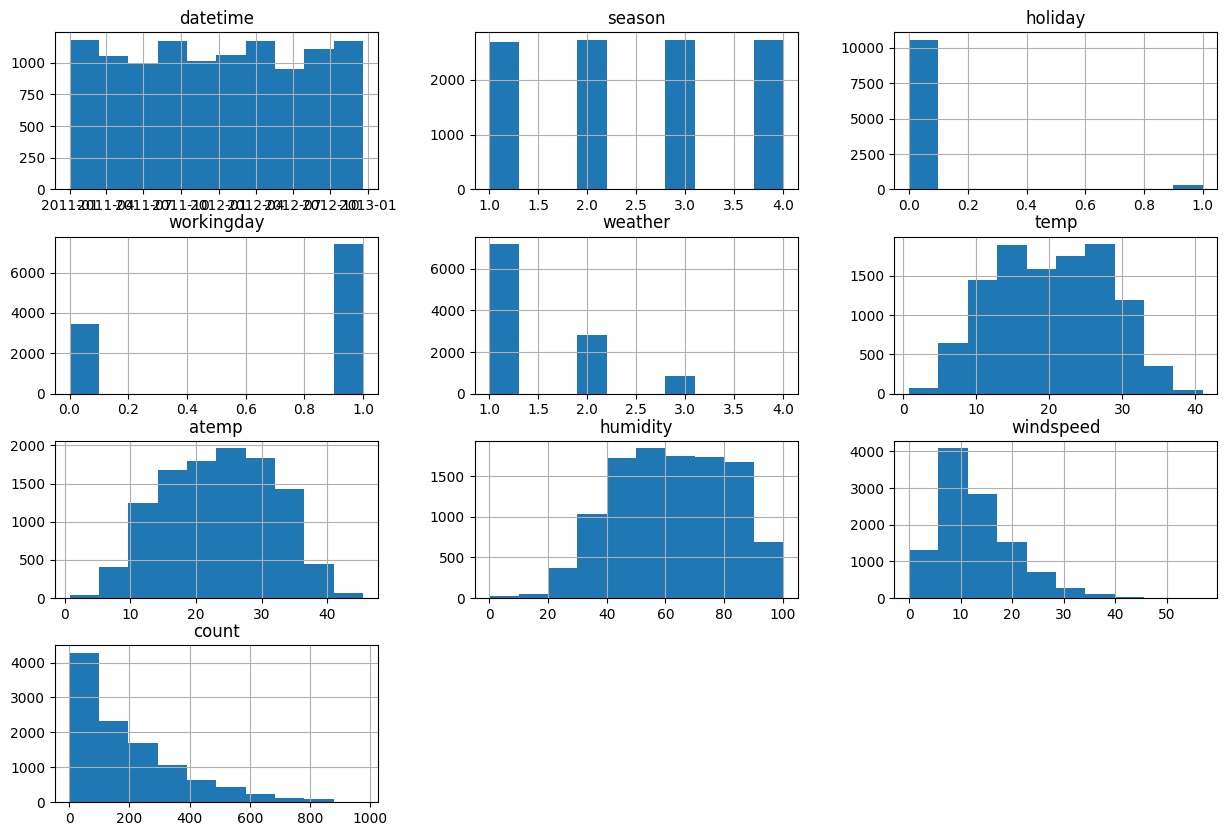

In [26]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist(figsize=(15, 10))

### What we observe about the data
- The scaling and distribution of the features is different
- Standardisation is needed
- But, lets experiment if spliting the datetime improves performance

In [27]:
# Split datatime into year, month and day

# First make a copy of the train and test data
train_new_features = train.copy()
test_new_features = test.copy()

# Create features
train_new_features['datetime_year'] = train_new_features.datetime.dt.year
train_new_features['datetime_month'] = train_new_features.datetime.dt.month
train_new_features['datetime_day'] = train_new_features.datetime.dt.day
train_new_features['datetime_hour'] = train_new_features.datetime.dt.hour


test_new_features['datetime_year'] = test_new_features.datetime.dt.year
test_new_features['datetime_month'] = test_new_features.datetime.dt.month
test_new_features['datetime_day'] = test_new_features.datetime.dt.day
test_new_features['datetime_hour'] = test_new_features.datetime.dt.hour

In [28]:
# Check if features created are correct
train_new_features.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,datetime_year,datetime_month,datetime_day,datetime_hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1,2011,1,1,4


In [29]:
# Remove datetime column
train_new_features.drop(columns=['datetime'], inplace=True)
test_new_features.drop(columns=['datetime'], inplace=True)

In [30]:
train_new_features.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,datetime_year,datetime_month,datetime_day,datetime_hour
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,191.574132,2011.501929,6.521495,9.992559,11.541613
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,181.144454,0.500019,3.444373,5.476608,6.915838
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,1.000000,2011.000000,1.000000,1.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,42.000000,2011.000000,4.000000,5.000000,6.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,145.000000,2012.000000,7.000000,10.000000,12.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,284.000000,2012.000000,10.000000,15.000000,18.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,977.000000,2012.000000,12.000000,19.000000,23.000000


## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [31]:
# Change data type to categorical
train_new_features["weather"] = train_new_features["weather"].astype("category")
train_new_features["season"] = train_new_features["season"].astype("category")

test_new_features["season"] = test_new_features["season"].astype("category")
test_new_features["weather"] = test_new_features["weather"].astype("category")

In [32]:
# View new feature
train_new_features.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,datetime_year,datetime_month,datetime_day,datetime_hour
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,2
3,1,0,0,1,9.84,14.395,75,0.0,13,2011,1,1,3
4,1,0,0,1,9.84,14.395,75,0.0,1,2011,1,1,4


array([[<AxesSubplot:title={'center':'holiday'}>,
        <AxesSubplot:title={'center':'workingday'}>,
        <AxesSubplot:title={'center':'temp'}>],
       [<AxesSubplot:title={'center':'atemp'}>,
        <AxesSubplot:title={'center':'humidity'}>,
        <AxesSubplot:title={'center':'windspeed'}>],
       [<AxesSubplot:title={'center':'count'}>,
        <AxesSubplot:title={'center':'datetime_year'}>,
        <AxesSubplot:title={'center':'datetime_month'}>],
       [<AxesSubplot:title={'center':'datetime_day'}>,
        <AxesSubplot:title={'center':'datetime_hour'}>, <AxesSubplot:>]],
      dtype=object)

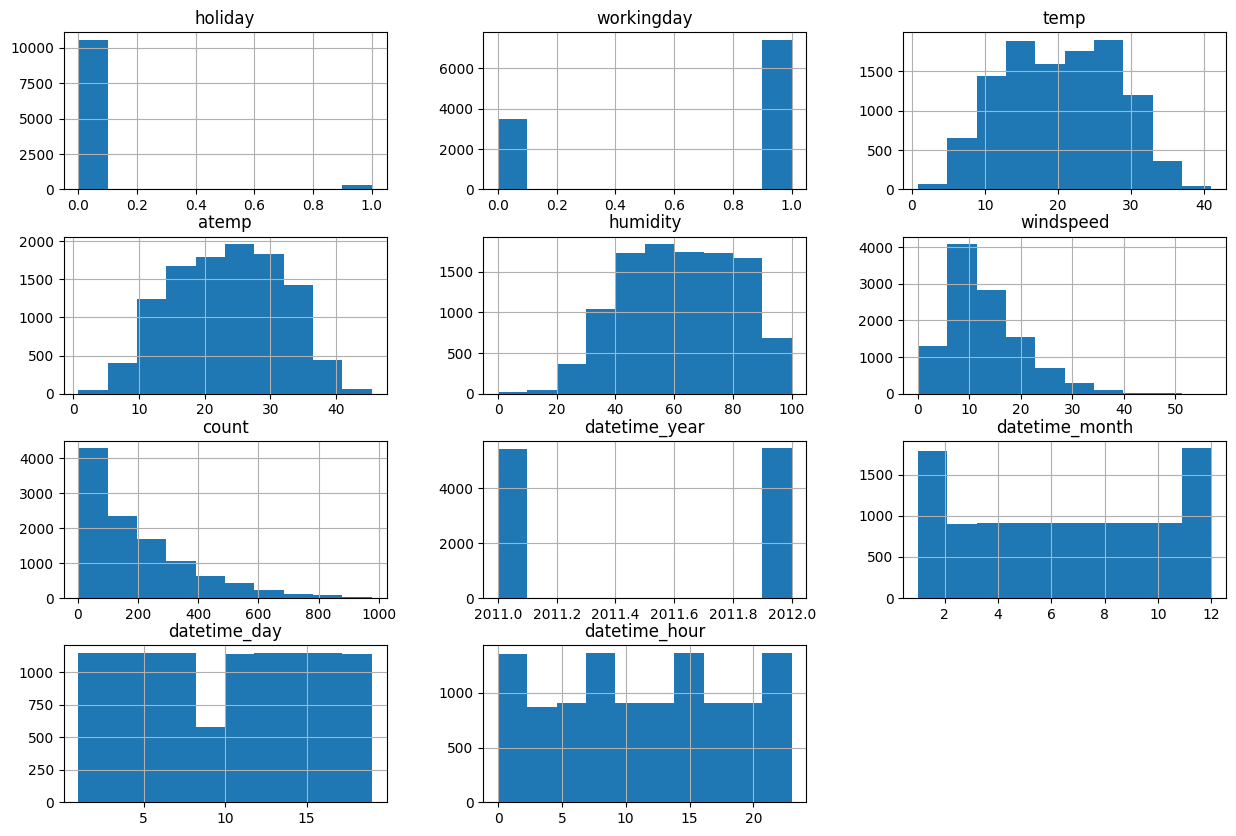

In [33]:
# View histogram of all features again now with the hour feature
train_new_features.hist(figsize=(15, 10))

## Step 5: Rerun the model with the same settings as before, just with more features

In [34]:
updated_features = test_new_features.columns.to_list()
train_new_features = train_new_features[updated_features + ['count']]
predictor_new_features = TabularPredictor(label='count', 
                             problem_type='regression', 
                             eval_metric='root_mean_squared_error').fit(train_new_features,
                                                                        time_limit=600, 
                                                                        presets="best_quality")

No path specified. Models will be saved in: "AutogluonModels/ag-20240805_130629/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20240805_130629/"
AutoGluon Version:  0.6.2
Python Version:     3.7.16
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Jun 18 14:00:06 UTC 2024
Train Data Rows:    10886
Train Data Columns: 12
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1544.03 MB
	Train Data (Original)  Memory Usage: 0.89 MB (0.1% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note

In [38]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -35.917353      43.610134  527.924822                0.001230           0.457091            3       True         14
1      WeightedEnsemble_L2  -35.918562      40.196953  361.534648                0.001149           0.720612            2       True          9
2          CatBoost_BAG_L2  -36.212664      42.579697  464.256567                0.151912          58.242543            2       True         13
3          LightGBM_BAG_L2  -36.298444      42.566638  433.121969                0.138854          27.107944            2       True         11
4   RandomForestMSE_BAG_L2  -36.704247      43.318138  442.117245                0.890353          36.103221            2       True         12
5        LightGBMXT_BAG_L2  -37.003651      42.927325  436.259514         

/home/sagemaker-user/.conda/envs/mle/lib/python3.7/site-packages/autogluon/core/utils/plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -123.93326033133124,
  'KNeighborsDist_BAG_L1': -119.3656013058329,
  'LightGBMXT_BAG_L1': -37.097828214696285,
  'LightGBM_BAG_L1': -37.69285008347025,
  'RandomForestMSE_BAG_L1': -42.14

In [39]:
# Remember to set all negative values to zero
predictions_new_features = predictor_new_features.predict(test_new_features)


In [40]:
# Check if prediction have less than zero values
predictions_new_features.describe()

count    6493.000000
mean      189.125076
std       172.796387
min         4.569957
25%        46.169003
50%       147.224548
75%       280.703827
max       875.161255
Name: count, dtype: float64

In [41]:
# Set values less than zero to zero
predictions_new_features[predictions_new_features < 0 ] = 0

In [42]:
# Same submitting predictions
submission["count"] = predictions_new_features.round().astype("int64")
submission.to_csv("submission_new_features.csv", index=False)

In [43]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100%|█████████████████████████████████████████| 149k/149k [00:00<00:00, 529kB/s]
Successfully submitted to Bike Sharing Demand

In [44]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_features.csv  2024-08-05 13:25:11  new features                       complete  0.47026      0.47026       
submission.csv               2024-08-05 13:04:10  first raw submission               complete  1.79587      1.79587       
submission_new_features.csv  2024-08-05 10:43:24  new features                       complete  0.47077      0.47077       
submission_new_hpo.csv       2024-08-02 18:04:46  new features with hyperparameters  complete  1.31677      1.31677       


#### New Score of `0.47026`

## Step 4b: Exploratory Data Analysis and Creating an additional feature
* From EDA and visualisation of the features distribution, the features have differnt scaling and distribution. Standardisation of features will make features to have the same range of values and importance to the model.
  
  - Feature standardisation applied to continous values
  - One hot encodeing is applied to categorical values

In [52]:
# create a new feature
from sklearn.preprocessing import StandardScaler

categorical_features = ['season', 'weather', 'holiday', 'workingday']
print(f"The following are categorical features:{categorical_features}")
# preprocessing to standardize data
continous_features = [val for val in test_new_features.columns.to_list() if val not in categorical_features]
print(f"The following are continous features:{continous_features}")


The following are categorical features:['season', 'weather', 'holiday', 'workingday']
The following are continous features:['temp', 'atemp', 'humidity', 'windspeed', 'datetime_year', 'datetime_month', 'datetime_day', 'datetime_hour']


In [53]:
# standardize continous valued features
scaler = StandardScaler().fit(train_new_features[continous_features])
train_new_features[continous_features] = scaler.transform(train_new_features[continous_features])
test_new_features[continous_features] = scaler.transform(test_new_features[continous_features])

In [67]:
# one hot encodign of categorical values. 'holiday', 'workingday' are excluded since they are boolean features
categorical_features = ['season', 'weather']
for feature in categorical_features:
    # update training data
    one_hot_data = pd.get_dummies(train_new_features[feature], prefix=f'{feature}_')
    train_new_features[one_hot_data.columns.to_list()] = one_hot_data
    # update test data
    one_hot_data = pd.get_dummies(test_new_features[feature], prefix=f'{feature}_')
    test_new_features[one_hot_data.columns.to_list()] = one_hot_data

    # remove pre the orginal features
    train_new_features.drop(columns=[feature], inplace=True)
    test_new_features.drop(columns=[feature], inplace=True)


array([[<AxesSubplot:title={'center':'holiday'}>,
        <AxesSubplot:title={'center':'workingday'}>,
        <AxesSubplot:title={'center':'temp'}>,
        <AxesSubplot:title={'center':'atemp'}>],
       [<AxesSubplot:title={'center':'humidity'}>,
        <AxesSubplot:title={'center':'windspeed'}>,
        <AxesSubplot:title={'center':'datetime_year'}>,
        <AxesSubplot:title={'center':'datetime_month'}>],
       [<AxesSubplot:title={'center':'datetime_day'}>,
        <AxesSubplot:title={'center':'datetime_hour'}>,
        <AxesSubplot:title={'center':'season__1'}>,
        <AxesSubplot:title={'center':'season__2'}>],
       [<AxesSubplot:title={'center':'season__3'}>,
        <AxesSubplot:title={'center':'season__4'}>,
        <AxesSubplot:title={'center':'weather__1'}>,
        <AxesSubplot:title={'center':'weather__2'}>],
       [<AxesSubplot:title={'center':'weather__3'}>,
        <AxesSubplot:title={'center':'weather__4'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=obj

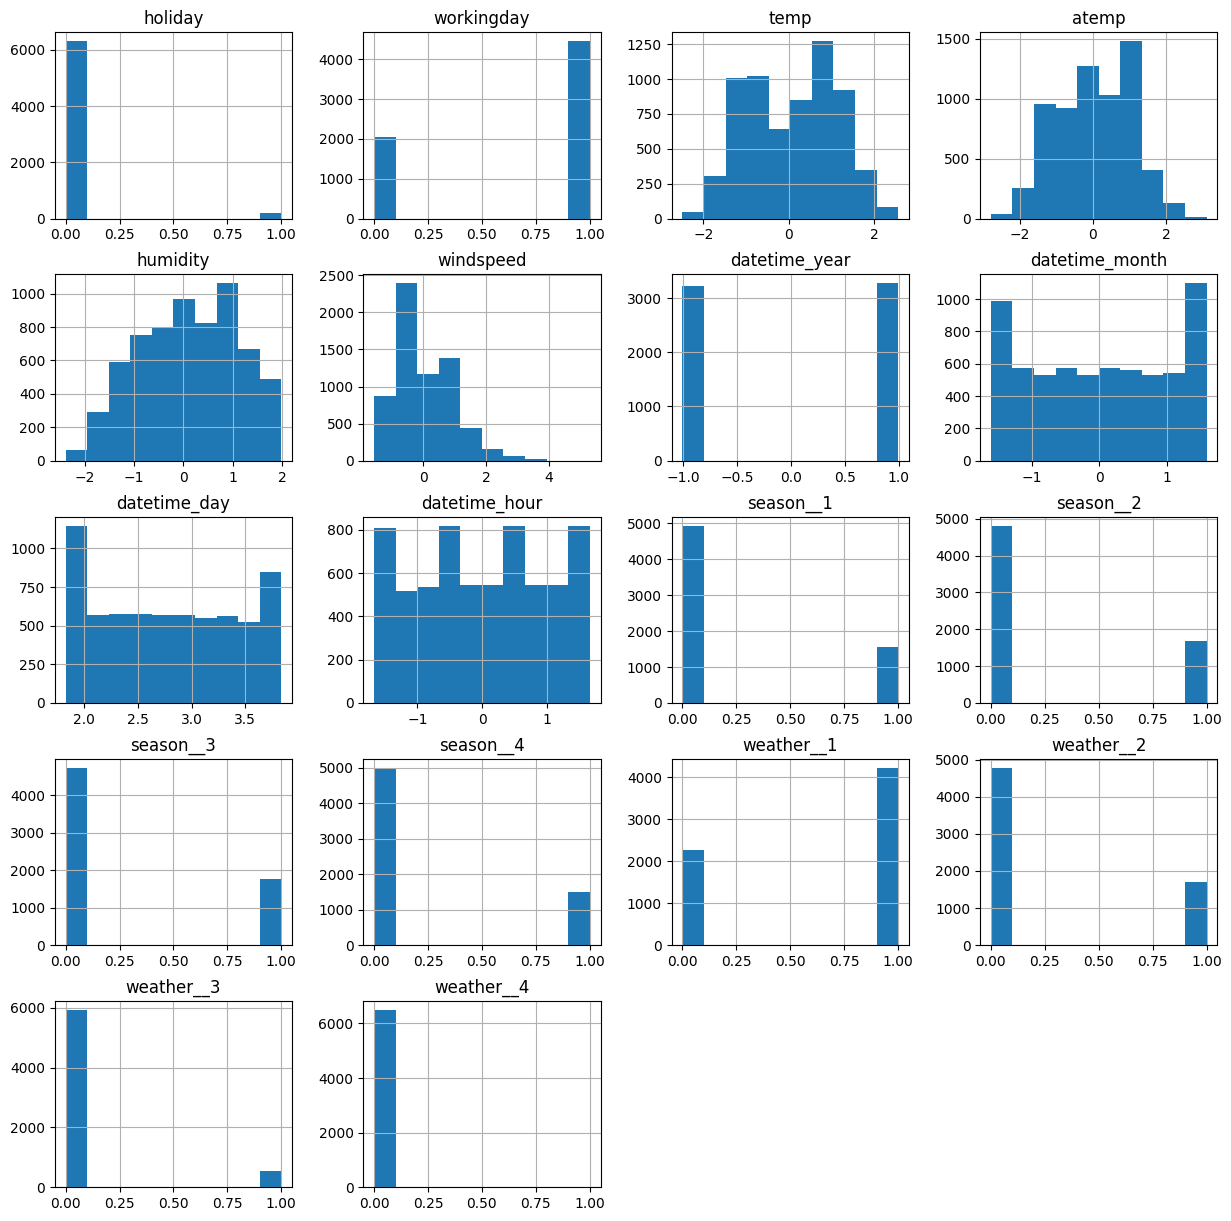

In [68]:
test_new_features.hist(figsize=(15, 15))

In [71]:
updated_features = test_new_features.columns.to_list()
train_new_features = train_new_features[updated_features + ['count']]
predictions_new_features_eng = TabularPredictor(label='count', 
                             problem_type='regression', 
                             eval_metric='root_mean_squared_error').fit(train_new_features,
                                                                        time_limit=600, 
                                                                        presets="best_quality")

No path specified. Models will be saved in: "AutogluonModels/ag-20240805_140248/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20240805_140248/"
AutoGluon Version:  0.6.2
Python Version:     3.7.16
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Jun 18 14:00:06 UTC 2024
Train Data Rows:    10886
Train Data Columns: 18
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    834.34 MB
	Train Data (Original)  Memory Usage: 0.96 MB (0.1% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note:

In [72]:
predictions_new_features_eng.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -35.888217      29.341096  511.480997                0.000758           0.400344            3       True         16
1      WeightedEnsemble_L2  -35.918122      26.422024  347.414728                0.000933           0.740193            2       True          9
2     ExtraTreesMSE_BAG_L2  -36.198069      28.500499  395.962438                0.838175          11.896091            2       True         14
3          CatBoost_BAG_L2  -36.199262      27.757366  426.842628                0.095042          42.776281            2       True         13
4          LightGBM_BAG_L2  -36.428051      27.759785  411.859509                0.097461          27.793162            2       True         11
5        LightGBMXT_BAG_L2  -37.102914      27.837662  407.142642         

/home/sagemaker-user/.conda/envs/mle/lib/python3.7/site-packages/autogluon/core/utils/plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -113.09050231789637,
  'KNeighborsDist_BAG_L1': -108.2266850216408

In [98]:
leaderboard = predictions_new_features_eng.leaderboard(train_new_features)
leaderboard

                     model  score_test   score_val  pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0    KNeighborsDist_BAG_L1   -1.714969 -108.226685        0.358831       0.312074    0.066197                 0.358831                0.312074           0.066197            1       True          2
1     ExtraTreesMSE_BAG_L1  -15.530819  -42.042991        0.996343       0.607026    4.001747                 0.996343                0.607026           4.001747            1       True          7
2   RandomForestMSE_BAG_L1  -15.564500  -42.256969        2.156900       0.805402   13.707747                 2.156900                0.805402          13.707747            1       True          5
3          LightGBM_BAG_L1  -16.617279  -37.874227       20.196509       4.251203   63.410624                20.196509                4.251203          63.410624            1       True          4
4          CatB

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,KNeighborsDist_BAG_L1,-1.714969,-108.226685,0.358831,0.312074,0.066197,0.358831,0.312074,0.066197,1,True,2
1,ExtraTreesMSE_BAG_L1,-15.530819,-42.042991,0.996343,0.607026,4.001747,0.996343,0.607026,4.001747,1,True,7
2,RandomForestMSE_BAG_L1,-15.564500,-42.256969,2.156900,0.805402,13.707747,2.156900,0.805402,13.707747,1,True,5
3,LightGBM_BAG_L1,-16.617279,-37.874227,20.196509,4.251203,63.410624,20.196509,4.251203,63.410624,1,True,4
4,CatBoost_BAG_L2,-17.339887,-36.199262,103.082937,27.757366,426.842628,0.164835,0.095042,42.776281,2,True,13
5,WeightedEnsemble_L3,-17.875406,-35.888217,108.208593,29.341096,511.480997,0.007687,0.000758,0.400344,3,True,16
6,WeightedEnsemble_L2,-17.951335,-35.918122,100.180120,26.422024,347.414728,0.006685,0.000933,0.740193,2,True,9
7,LightGBMXT_BAG_L2,-18.125658,-37.102914,103.990977,27.837662,407.142642,1.072875,0.175338,23.076295,2,True,10
8,LightGBM_BAG_L2,-18.133802,-36.428051,103.516073,27.759785,411.859509,0.597972,0.097461,27.793162,2,True,11
9,LightGBMXT_BAG_L1,-18.696601,-37.312587,76.288205,20.574245,113.911455,76.288205,20.574245,113.911455,1,True,3


In [73]:
# Get prediction on test data
prediction_new_features_eng = predictions_new_features_eng.predict(test_new_features)

In [74]:
# Describe prediction data
prediction_new_features_eng.describe()

count    6493.000000
mean      189.251633
std       172.914337
min         3.817812
25%        46.998245
50%       146.331680
75%       282.931213
max       882.659363
Name: count, dtype: float64

In [77]:
# Same submitting predictions
submission["count"] = prediction_new_features_eng.round().astype("int64")
submission.to_csv("submission_new_features_eng.csv", index=False)

In [78]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features_eng.csv -m "new features engineering"


100%|█████████████████████████████████████████| 149k/149k [00:00<00:00, 544kB/s]
Successfully submitted to Bike Sharing DemandfileName                         date                 description                        status    publicScore  privateScore  
-------------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_features_eng.csv  2024-08-05 14:29:25  new features engineering           pending                              
submission_new_features.csv      2024-08-05 13:25:11  new features                       complete  0.47026      0.47026       
submission.csv                   2024-08-05 13:04:10  first raw submission               complete  1.79587      1.79587       
submission_new_features.csv      2024-08-05 10:43:24  new features                       complete  0.47077      0.47077       


In [80]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                         date                 description                        status    publicScore  privateScore  
-------------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_features_eng.csv  2024-08-05 14:29:25  new features engineering           complete  0.46593      0.46593       
submission_new_features.csv      2024-08-05 13:25:11  new features                       complete  0.47026      0.47026       
submission.csv                   2024-08-05 13:04:10  first raw submission               complete  1.79587      1.79587       
submission_new_features.csv      2024-08-05 10:43:24  new features                       complete  0.47077      0.47077       


#### New Score of `0.46593`

## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [102]:
from autogluon.core import space

# nn_options = {  # specifies non-default hyperparameter values for neural network models
#     'num_epochs': 50,  # number of training epochs (controls training time of NN models)
#     'learning_rate': space.Real(1e-4, 1e-2, default=5e-4, log=True),  # learning rate used in training (real-valued hyperparameter searched on log-scale)
#     'dropout_prob': space.Real(0.0, 0.5, default=0.1),  # dropout probability (real-valued hyperparameter)
# }

# hyperparameters = { 
#                    'NN_TORCH': nn_options,
#                   } 

hyperparameters = {
    'NN': {'num_epochs': 50, 'learning_rate': space.Real(1e-4, 1e-2, default=5e-4)},
    'GBM': {'num_boost_round': 100},
    'CAT': {'iterations': 500},
    'XGB': {'n_estimators': 100},
    'RF': {'n_estimators': 100},
    'XT': {'n_estimators': 100},
    'KNN': {'n_neighbors': 5},
    'LR': {},
    # 'custom': ['GBM']  # Example of including a custom model
}
time_limit = 900 
num_trials = 5  # try at most 5 different hyperparameter configurations for each type of model
search_strategy = 'auto'  # to tune hyperparameters using random search routine with a local scheduler

hyperparameter_tune_kwargs = {
    'num_trials': num_trials,
    'scheduler' : 'local',
    'searcher': search_strategy,
}  # Refer to TabularPredictor.fit docstring for all valid values

predictor_new_hpo = TabularPredictor(label='count', 
                             problem_type='regression', 
                             eval_metric='root_mean_squared_error').fit(train_new_features, time_limit=time_limit, 
                                                                        presets="best_quality",
                                                                       hyperparameters=hyperparameters,
                                                                       hyperparameter_tune_kwargs=hyperparameter_tune_kwargs)

No path specified. Models will be saved in: "AutogluonModels/ag-20240805_154115/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 900s
AutoGluon will save models to "AutogluonModels/ag-20240805_154115/"
AutoGluon Version:  0.6.2
Python Version:     3.7.16
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Jun 18 14:00:06 UTC 2024
Train Data Rows:    10886
Train Data Columns: 18
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    997.43 MB
	Train Data (Original)  Memory Usage: 0.96 MB (0.1% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note:

In [103]:
predictor_new_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                       model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0        WeightedEnsemble_L3  -38.084541       3.538530  731.148476                0.000778           0.382996            3       True         20
1        WeightedEnsemble_L2  -38.386245       0.275635  116.274028                0.001600           0.754665            2       True         12
2         LightGBM_BAG_L2/T1  -38.451226       3.534540  574.194140                0.000134          30.130421            2       True         13
3         CatBoost_BAG_L2/T1  -38.539901       3.536869  593.582953                0.002463          49.519234            2       True         15
4          ExtraTrees_BAG_L2  -38.840170       3.534610  549.778712                0.000204           5.714993            2       True         16
5          XGBoost_BAG_L2/T1  -38.861919       3.534531  573.6

/home/sagemaker-user/.conda/envs/mle/lib/python3.7/site-packages/autogluon/core/utils/plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighbors_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBM_BAG_L1/T1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T2': 'StackerEnsembleModel_LGB',
  'RandomForest_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1/T1': 'StackerEnsembleModel_CatBoost',
  'CatBoost_BAG_L1/T2': 'StackerEnsembleModel_CatBoost',
  'ExtraTrees_BAG_L1': 'StackerEnsembleModel_XT',
  'XGBoost_BAG_L1/T1': 'StackerEnsembleModel_XGBoost',
  'XGBoost_BAG_L1/T2': 'StackerEnsembleModel_XGBoost',
  'LinearModel_BAG_L1': 'StackerEnsembleModel_Linear',
  'NeuralNetMXNet_BAG_L1/T1': 'StackerEnsembleModel_TabularNeuralNetMxnet',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBM_BAG_L2/T1': 'StackerEnsembleModel_LGB',
  'RandomForest_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2/T1': 'StackerEnsembleModel_CatBoost',
  'ExtraTrees_BAG_L2': 'StackerEnsembleModel_XT',
  'XGBoost_BAG_L2/T1': 'StackerEnsembleModel_XGBoost',
  'LinearModel_BAG_L2': 'StackerEnsembleModel_Linear',
  

In [105]:
# Remember to set all negative values to zero
predictor_new_hpo_predictions = predictor_new_hpo.predict(test_new_features)
predictor_new_hpo_predictions[predictor_new_hpo_predictions < 0] = 0

In [106]:
# Same submitting predictions
submission["count"] = predictor_new_hpo_predictions
submission[["datetime", "count"]].to_csv("submission_new_hpo.csv", index=False)

In [107]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 652kB/s]
Successfully submitted to Bike Sharing Demand

In [109]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                         date                 description                        status    publicScore  privateScore  
-------------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_hpo.csv           2024-08-05 16:01:51  new features with hyperparameters  complete  0.45236      0.45236       
submission_new_hpo.csv           2024-08-05 15:13:50  new features with hyperparameters  complete  0.57751      0.57751       
submission_new_features_eng.csv  2024-08-05 14:29:25  new features engineering           complete  0.46593      0.46593       
submission_new_features.csv      2024-08-05 13:25:11  new features                       complete  0.47026      0.47026       


#### New Score of `0.45236`

## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

Text(0.5, 1.0, 'Model score from each training')

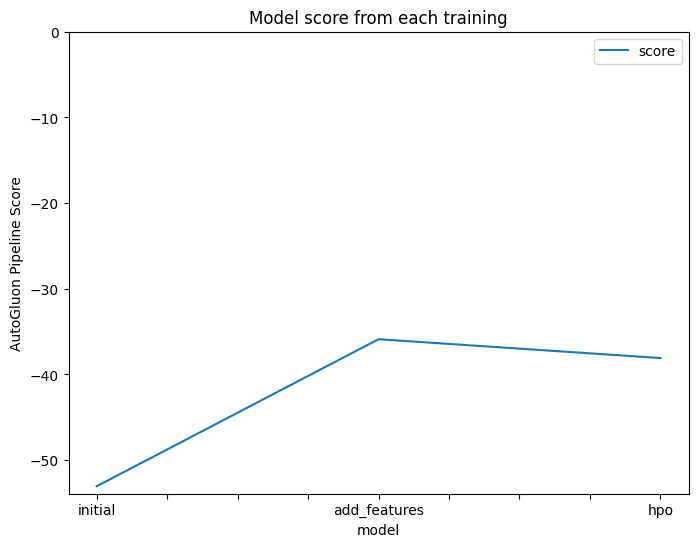

In [118]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
import matplotlib.pyplot as plt
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [-53.040612, -35.888217, -38.084541]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')
plt.ylabel("AutoGluon Pipeline Score")
plt.ylim(None, 0)
plt.title("Model score from each training")

Text(0.5, 1.0, 'Kaggle Score')

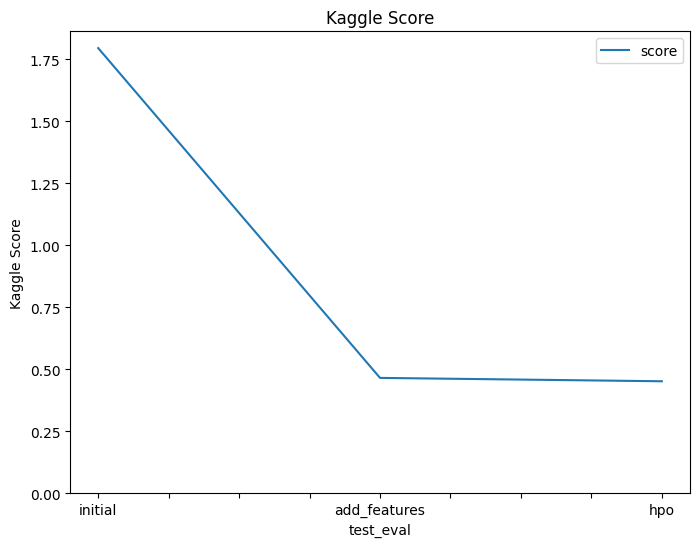

In [119]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [1.79587, 0.46593, 0.45236]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')
plt.ylabel("Kaggle Score")
plt.ylim(0, None)
plt.title("Kaggle Score")

### Hyperparameter table

In [110]:
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "Time_limit": [600, 600, 900],
    "num_trails": ['--', '--', 5],
    "num_epochs": ['default', 'default', 50],
    "score": [1.79587, 0.46593, 0.45236]
})

,model,Time_limit,num_trails,num_epochs,score
0,initial,600,--,default,1.79587
1,add_features,600,--,default,0.46593
2,hpo,900,5,50,0.45236
